# Convert .mat file to hdf5 python format

This notebook take original stim file of the checkerboard, add repeated frame for a particular experiment and create a hdf5 file. The output axis are (frame, y, x, channel).

Note:

 * HDF5 describes data set dimensions in **row-major order**; MATLAB stores data in **column-major order**.For example, if Matlab (Fortran) writes a 35x31x3x100 four-dimensional dataset to the file, a Python (wrote in C) program will read it as a 100x3x31x35 four-dimensional dataset from memory. 
 * Scipy.io.loadmat only soppourt version of mat file less than 7.3. To read version 7.3 we need to read as hdf5 file.   
 * Scipy.io.loadmat transfor data to **row-major order** but keep the same axis orden that MATLAB


In [1]:
from configparser import ConfigParser, ExtendedInterpolation

import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.io import loadmat
from spikelib.stimtools import correct_checkerboard
from spikelib.utils import check_directory

%matplotlib notebook

config = ConfigParser(interpolation=ExtendedInterpolation())
config.read('../../config.ini')

['../../config.ini']

In [2]:
stim_file_raw = config['FILES']['wn_stim_raw']
events_file = config['SYNC']['events']
frametime_file = config['SYNC']['frametime']
repeated_file = config['SYNC']['repeated']
output_sync_file = config['FILES']['wn_stim']
protocol_name = config['CHECKERBOARD']['protocol_name']
checkerboard_output_file = config['SYNC']['folder'] + 'checkerboard.txt'

In [3]:
frametimes = np.loadtxt(frametime_file)
df = pd.read_csv(events_file)
checkerboard_times = df[df['protocol_name'] == protocol_name]

In [4]:
checkerboard_times

,n_frames,start_event,end_event,start_next_event,event_duration,event_duration_seg,inter_event_duration,inter_event_duration_seg,protocol_name,nd,intensity,extra_desciption,repetition_name,repeated_frames,#repeated_frames
1,108000,12091205,48211517,48275752,36120312,1806.0156,64235,3.21175,checkerboard,nd3,255.0,cyan,rep_000,[],0


In [5]:
event = checkerboard_times.iloc[0]
sync_file = frametimes[np.logical_and(frametimes[:, 0] >= event.start_event,
                                         frametimes[:, 0] < event.end_event), :]
np.savetxt(checkerboard_output_file, sync_file)


inputs:   
* **stim_file** : stim in .mat format
* **sync_file** : txt file to checkerboar_file with start and end time. To generate this file use [Get-sync notebook](../utils/UTIL_sync_get-sync-file.ipynb)
* **repeated_file** : txt file with all repeated frame To generate this file use [Get-sync notebook](../utils/UTIL_sync_get-sync-file.ipynb)
* **outputfile** : full path to save converted stimulus


In [6]:
correct_checkerboard(stim_file_raw, checkerboard_output_file, repeated_file, output_sync_file)

Shape for checkerboar file: (108000, 31, 31, 3)
Repeated frame []


# Check the correct convertion 

## Load Data from log file and new stim file

In [7]:
# Load First image from log file
first_img_file = '../../data/logs/Exp__2014_08_20-14.55.17/FirstImages_2.mat'
corrected_file = output_sync_file

first_img = loadmat(first_img_file)['fi']
print('First Image: ',first_img.dtype,first_img.shape)

# Load corrected stim file
with h5py.File(corrected_file,'r') as stim:
    print('Stim Image: ',stim['checkerboard'].dtype, stim['checkerboard'].shape)
    corrected_stim = stim['checkerboard'][:3]

First Image:  uint8 (372, 372, 3, 3)
Stim Image:  uint8 (108000, 31, 31, 3)


## Plot first images

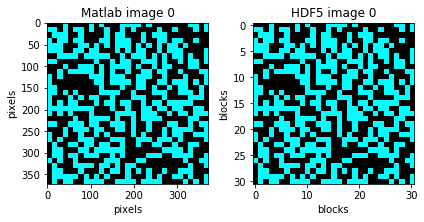

In [8]:
idx_img = 0
plt.figure()
plt.subplot(1,2,1).set_title('Matlab image {}'.format(idx_img))
plt.imshow(first_img[...,idx_img])
plt.xlabel('pixels')
plt.ylabel('pixels')
plt.subplot(1,2,2).set_title('HDF5 image {}'.format(idx_img))
plt.imshow(corrected_stim[idx_img])
plt.xlabel('blocks')
plt.ylabel('blocks')
plt.tight_layout()
# plt.savefig('../figures/first_image_checkerboar.png')

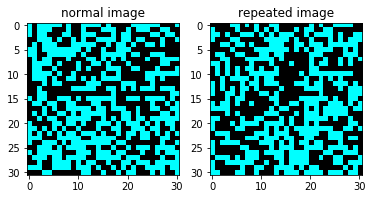

In [9]:
idx_repeated = 54803
# Load corrected stim file

plt.figure()
with h5py.File(corrected_file,'r') as stim:
    print(stim.attrs['repeated'])
    plt.subplot(1,2,1).set_title('normal image')
    plt.imshow(stim['checkerboard'][idx_repeated,...])
    plt.subplot(1,2,2).set_title('repeated image')
    plt.imshow(stim['checkerboard'][idx_repeated+1,...])
# plt.savefig('../figures/first_imag28232e_checkerboar.png')